In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import nltk
import json

In [ ]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Emotion-Detection')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Emotion-Detection/dataset_final_preprocessed.csv')
df.head(10)
df['Emotion'].unique()

array(['Happy', 'Sad', 'Fear', 'Anger', 'Bad', 'Surprise', 'Digust'],
      dtype=object)

In [ ]:
import pickle
infile = open('/content/drive/My Drive/Emotion-Detection/tokenizer.pickle','rb')
tokenizer = pickle.load(infile)
infile.close()

In [ ]:
df.columns

Index(['Text', 'Emotion'], dtype='object')

In [ ]:
max_num = 0
for text in df['Text'].values:
  max_num = max(len(str(text).split()),max_num)
input_length = max_num

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

import os
import sys
from pathlib import Path

sequences = [str(text).split() for text in df['Text'].values]
tokenized = tokenizer.texts_to_sequences(sequences)
pad_data = pad_sequences(tokenized,input_length)

encoder = LabelBinarizer()
encoder.fit(df['Emotion'].unique())
encoder_path = Path('/content/drive/My Drive/Emotion-Detection', 'encoder.pickle')
with encoder_path.open('wb') as file:
    pickle.dump(encoder, file)
label = encoder.transform(df['Emotion'].values)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pad_data,label, test_size=0.20, random_state=42)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential

Using TensorFlow backend.


In [ ]:
input_dim = len(tokenizer.word_index) + 1
num_classes = len(df['Emotion'].unique())
embedding_dim = 500
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [ ]:
dictionary = {'input_dim':input_dim,'num_classes':num_classes,'input_length':input_length}
with open('/content/drive/My Drive/Emotion-Detection/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)
dictionary

{'input_dim': 109391, 'input_length': 157, 'num_classes': 7}

In [ ]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 157)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 157, 500)     54695500    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 157, 256)     644096      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 155, 64)      49216       bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
# from keras.layers import Dense,Activation,Dropout,Conv1D,Flatten
# from keras.layers import Embedding
# model = Sequential()
# model.add(Embedding(input_dim=input_dim,output_dim=embedding_dim,input_shape=(input_length,)))
# model.add(Conv1D(128,3,padding = 'same'))
# model.add(Conv1D(64,3,padding = 'same'))
# model.add(Conv1D(32,2,padding = 'same'))
# model.add(Conv1D(16,2,padding = 'same'))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(100,activation = 'sigmoid'))
# model.add(Dropout(0.2))
# model.add(Dense(num_classes, activation='softmax'))
# model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
# model.summary()

In [ ]:
batch_size = 128
epochs = 1
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test))

1301/1301 [==============================] - 2871s 2s/step - loss: 0.4460 - accuracy: 0.8372 - val_loss: 0.3641 - val_accuracy: 0.8649


In [ ]:
model_json = model.to_json()
with open('/content/drive/My Drive/Emotion-Detection/lstm_model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('/content/drive/My Drive/Emotion-Detection/lstm_model.h5')

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [ ]:
# import sys
# sys.path.insert(1, '/content/drive/My Drive/Emotion-Detection')
# data_classes = np.array(list(df['Emotion'].unique()))
# import accuracy as ev
# ev.display_model_performance_metrics(model,x_test,y_test, data_classes,True,'lstm_confusion_matrix',True)

In [ ]:
model_file = Path('/content/drive/My Drive/Emotion-Detection/lstm_model_weights.h5').resolve()
model.save_weights(model_file.as_posix())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

Normalized confusion matrix


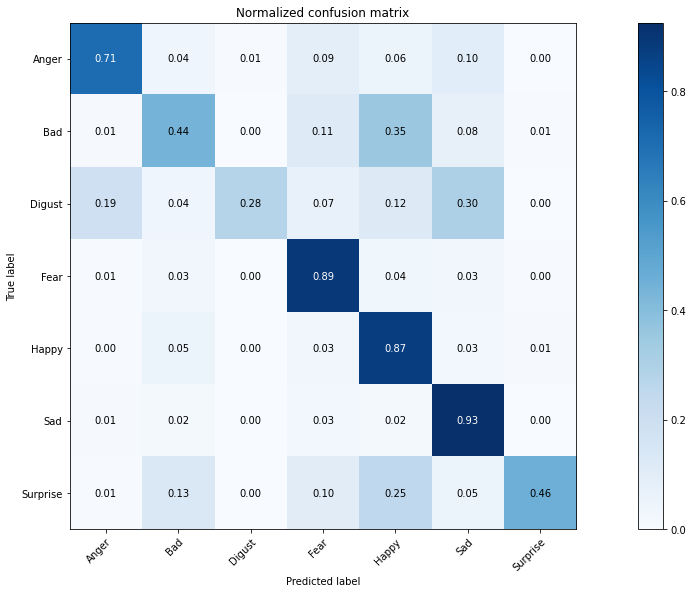

In [ ]:
fig, ax = plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('/content/drive/My Drive/Emotion-Detection/dl_lstm_confusion_matrix.png')
